In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
path = "/content/drive/MyDrive/Dataset/KaggleV2-May-2016.csv"
df = pd.read_csv(path)
df = df.copy()

In [ ]:
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)
df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

In [ ]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['WaitingTime'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

df = df[df['WaitingTime'] >= 0].copy()
df.loc[:, 'AppointmentWeekday'] = df['AppointmentDay'].dt.dayofweek
# df.loc[:, 'Neighbourhood'] = pd.factorize(df['Neighbourhood'])[0]

# df['Neighbourhood'] = pd.factorize(df['Neighbourhood'])[0]
# print(df['Neighbourhood'].dtype)



features = [
    'Gender', 'Age',  'Scholarship',
    'Hipertension', 'Diabetes' , 'Handcap',
    'SMS_received', 'WaitingTime', 'AppointmentWeekday'
]
# print(df[features].isnull().sum())
# print(np.isinf(df[features]).sum())
print(df[features].dtypes)


Gender                int64
Age                   int64
Scholarship           int64
Hipertension          int64
Diabetes              int64
Handcap               int64
SMS_received          int64
WaitingTime           int64
AppointmentWeekday    int32
dtype: object


In [ ]:
X = df[features].to_numpy()
y = df['No-show'].to_numpy()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1

X_scaled = (X - X_mean) / X_std

# --------------------  Shuffle and Split --------------------
np.random.seed(42)
indices = np.arange(X_scaled.shape[0])
np.random.shuffle(indices)

# 80-20 split
split_idx = int(0.8 * len(indices))
train_idx, val_idx = indices[:split_idx], indices[split_idx:]

X_train, y_train = X_scaled[train_idx], y[train_idx]
X_val, y_val = X_scaled[val_idx], y[val_idx]

In [ ]:
num_pos = np.sum(y_train)
num_neg = len(y_train) - num_pos

w0 = 1
w1 = num_neg / (num_pos)


print(w0,w1)

1 2.5222099853157123


In [ ]:
# w0 = len(y_train) / (2 * num_neg)
# w1 = len(y_train) / (2 * num_pos)
# print(w0, w1)

In [ ]:
print(num_pos)
print(num_neg)

16344
41223


In [ ]:
def he_initialization(n_in, n_out):
    std_dev = np.sqrt(2.0 / n_in)
    return np.random.randn(n_in, n_out) * std_dev


In [ ]:
def xavier_initialization(n_in, n_out):
    limit = np.sqrt(6.0 / (n_in + n_out))
    return np.random.uniform(-limit, limit, (n_in, n_out))


In [ ]:
class Layer_Dense:

    def __init__(self, n_inputs, n_neurons, initialization):
        if initialization == 'he':
            self.weights = he_initialization(n_inputs, n_neurons)
        elif initialization == 'xavier':
            self.weights = xavier_initialization(n_inputs, n_neurons)
        # self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.dot(inputs, self.weights) +  self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

In [ ]:
class Activation_ReLU:

    def forward(self, inputs):
        self.inputs = inputs

        self.output = np.maximum(0,inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

        self.dinputs[self.inputs <= 0] = 0


class Sigmoid_Activation:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output ) * self.output

In [ ]:
class wieghted_binarycrossentropy():
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        sample_losses = -(w1 * y_true * np.log(y_pred_clipped) + w0 * (1 - y_true) * np.log(1 - y_pred_clipped))
        mean_loss = np.mean(sample_losses)
        self.output = mean_loss
        return mean_loss


    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        clipped_values = np.clip(dvalues, 1e-7, 1 - 1e-7)
        # self.dinputs = -(y_true / clipped_values - (1 - y_true) / (1 - clipped_values)) / samples
        self.dinputs = -(w1 * y_true / clipped_values - w0 * (1 - y_true) / (1 - clipped_values)) / samples


In [ ]:

class Optimizer_SGD:

    def __init__(self, learning_rate = 0.03):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

In [ ]:
def get_batches(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled, y_shuffled = X[indices], y[indices]
    for i in range(0, len(X), batch_size):

        yield X_shuffled[i:i + batch_size], y_shuffled[i:i + batch_size]


In [ ]:
print(X_train.shape)
print(y_train.shape)

(57567, 9)
(57567,)


In [ ]:
dense1 = Layer_Dense(X_train.shape[1], 64, 'he')
activation1 = Activation_ReLU()

# dense2 = Layer_Dense(128,64, 'he')
# activation2 = Activation_ReLU()


# dense2.O = Layer_Dense(64,32, 'he')
# activation2.O = Activation_ReLU()

dense3 = Layer_Dense(64, 32, 'he')
activation3 = Activation_ReLU()

dense4 = Layer_Dense(32, 1, 'xavier')
activation4 = Sigmoid_Activation()

loss_function = wieghted_binarycrossentropy()
optimizer = Optimizer_SGD()

In [ ]:
from tqdm import trange

In [ ]:
# Training loop with batching
loss_history = []
batch_size = 1024
epochs = 2000

initial_lr = 0.1
decay_rate = 0.01
lr_history = []

start_time = time.time()
for epoch in trange(epochs,desc="Training Epochs"):
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = 0

    current_lr = initial_lr / (1 + decay_rate * epoch)
    optimizer.learning_rate = current_lr
    lr_history.append(current_lr)


    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        # Forward pass
        dense1.forward(X_batch)
        activation1.forward(dense1.outputs)

        # dense2.forward(activation1.output)
        # activation2.forward(dense2.outputs)

        # dense2.O.forward(activation2.output)
        # activation2.O.forward(dense2.O.outputs)


        dense3.forward(activation1.output)
        activation3.forward(dense3.outputs)

        dense4.forward(activation3.output)
        activation4.forward(dense4.outputs)

        # Compute loss
        loss = loss_function.forward(activation4.output, y_batch.reshape(-1, 1))
        # epoch_loss += loss


        # Accuracy
        predictions = (activation4.output > 0.5).astype(int).flatten()
        accuracy = np.mean(predictions == y_batch)
        epoch_accuracy += accuracy

        # Backward pass
        loss_function.backward(activation4.output, y_batch.reshape(-1, 1))
        activation4.backward(loss_function.dinputs)
        dense4.backward(activation4.dinputs)
        activation3.backward(dense4.dinputs)
        dense3.backward(activation3.dinputs)
        # activation2.O.backward(dense3.dinputs)
        # dense2.O.backward(activation2.O.dinputs)
        # activation2.backward(dense3.dinputs)
        # dense2.backward(activation2.dinputs)
        activation1.backward(dense3.dinputs)
        dense1.backward(activation1.dinputs)

        # Update weights
        optimizer.update_params(dense1)
        # optimizer.update_params(dense2)
        # optimizer.update_params(dense2.O)
        optimizer.update_params(dense3)
        optimizer.update_params(dense4)
        num_batches += 1


        loss = loss_function.forward(activation4.output, y_batch.reshape(-1, 1))
        epoch_loss += loss

    loss_history.append(epoch_loss / num_batches)
    # print(f'Epoch {epoch} : {epoch_loss/num_batches}')
    # Epoch summary
    if epoch % 100 == 0:
      # print(epoch_loss)
      print(f"Epoch {epoch}, Learning Rate: {current_lr:.6f}")
      print(f"Epoch {epoch}, Accuracy: {epoch_accuracy / num_batches:.3f}, Loss: {epoch_loss / num_batches:.3f}")
end_time = time.time()

Convergence_time = end_time - start_time
print(f"Convergence Time: {Convergence_time:.2f} seconds")

Training Epochs:   0%|          | 1/2000 [00:02<1:35:40,  2.87s/it]

Epoch 0, Learning Rate: 0.100000
Epoch 0, Accuracy: 0.549, Loss: 1.000


Training Epochs:   5%|▌         | 101/2000 [01:00<07:43,  4.10it/s]

Epoch 100, Learning Rate: 0.050000
Epoch 100, Accuracy: 0.579, Loss: 0.965


Training Epochs:  10%|█         | 201/2000 [01:32<07:19,  4.10it/s]

Epoch 200, Learning Rate: 0.033333
Epoch 200, Accuracy: 0.583, Loss: 0.962


Training Epochs:  15%|█▌        | 301/2000 [02:06<12:54,  2.19it/s]

Epoch 300, Learning Rate: 0.025000
Epoch 300, Accuracy: 0.583, Loss: 0.960


Training Epochs:  20%|██        | 401/2000 [02:40<22:38,  1.18it/s]

Epoch 400, Learning Rate: 0.020000
Epoch 400, Accuracy: 0.583, Loss: 0.959


Training Epochs:  25%|██▌       | 501/2000 [03:12<08:00,  3.12it/s]

Epoch 500, Learning Rate: 0.016667
Epoch 500, Accuracy: 0.583, Loss: 0.958


Training Epochs:  30%|███       | 601/2000 [03:43<05:56,  3.92it/s]

Epoch 600, Learning Rate: 0.014286
Epoch 600, Accuracy: 0.586, Loss: 0.958


Training Epochs:  35%|███▌      | 701/2000 [04:15<04:58,  4.35it/s]

Epoch 700, Learning Rate: 0.012500
Epoch 700, Accuracy: 0.586, Loss: 0.957


Training Epochs:  40%|████      | 801/2000 [04:46<04:46,  4.19it/s]

Epoch 800, Learning Rate: 0.011111
Epoch 800, Accuracy: 0.592, Loss: 0.955


Training Epochs:  45%|████▌     | 901/2000 [05:17<04:11,  4.37it/s]

Epoch 900, Learning Rate: 0.010000
Epoch 900, Accuracy: 0.589, Loss: 0.956


Training Epochs:  50%|█████     | 1001/2000 [05:48<03:51,  4.32it/s]

Epoch 1000, Learning Rate: 0.009091
Epoch 1000, Accuracy: 0.587, Loss: 0.956


Training Epochs:  55%|█████▌    | 1101/2000 [06:20<03:31,  4.26it/s]

Epoch 1100, Learning Rate: 0.008333
Epoch 1100, Accuracy: 0.590, Loss: 0.955


Training Epochs:  60%|██████    | 1201/2000 [06:51<03:09,  4.23it/s]

Epoch 1200, Learning Rate: 0.007692
Epoch 1200, Accuracy: 0.588, Loss: 0.956


Training Epochs:  65%|██████▌   | 1301/2000 [07:23<02:51,  4.07it/s]

Epoch 1300, Learning Rate: 0.007143
Epoch 1300, Accuracy: 0.587, Loss: 0.954


Training Epochs:  70%|███████   | 1401/2000 [07:58<09:15,  1.08it/s]

Epoch 1400, Learning Rate: 0.006667
Epoch 1400, Accuracy: 0.587, Loss: 0.955


Training Epochs:  75%|███████▌  | 1501/2000 [08:29<02:36,  3.18it/s]

Epoch 1500, Learning Rate: 0.006250
Epoch 1500, Accuracy: 0.593, Loss: 0.955


Training Epochs:  80%|████████  | 1601/2000 [09:04<01:40,  3.97it/s]

Epoch 1600, Learning Rate: 0.005882
Epoch 1600, Accuracy: 0.590, Loss: 0.955


Training Epochs:  85%|████████▌ | 1701/2000 [09:36<01:09,  4.33it/s]

Epoch 1700, Learning Rate: 0.005556
Epoch 1700, Accuracy: 0.593, Loss: 0.953


Training Epochs:  90%|█████████ | 1801/2000 [10:07<00:47,  4.18it/s]

Epoch 1800, Learning Rate: 0.005263
Epoch 1800, Accuracy: 0.592, Loss: 0.954


Training Epochs:  95%|█████████▌| 1901/2000 [10:39<00:22,  4.41it/s]

Epoch 1900, Learning Rate: 0.005000
Epoch 1900, Accuracy: 0.595, Loss: 0.953


Training Epochs: 100%|██████████| 2000/2000 [11:10<00:00,  2.98it/s]

Convergence Time: 670.81 seconds


In [ ]:
print("First logged loss (epoch 0):", loss_history[0])
print(loss_history[:5])
print(len(loss_history))

First logged loss (epoch 0): 1.0001106044605974
[np.float64(1.0001106044605974), np.float64(0.9818320715040497), np.float64(0.9760784326751053), np.float64(0.9753088888180885), np.float64(0.9743138217934529)]
2000


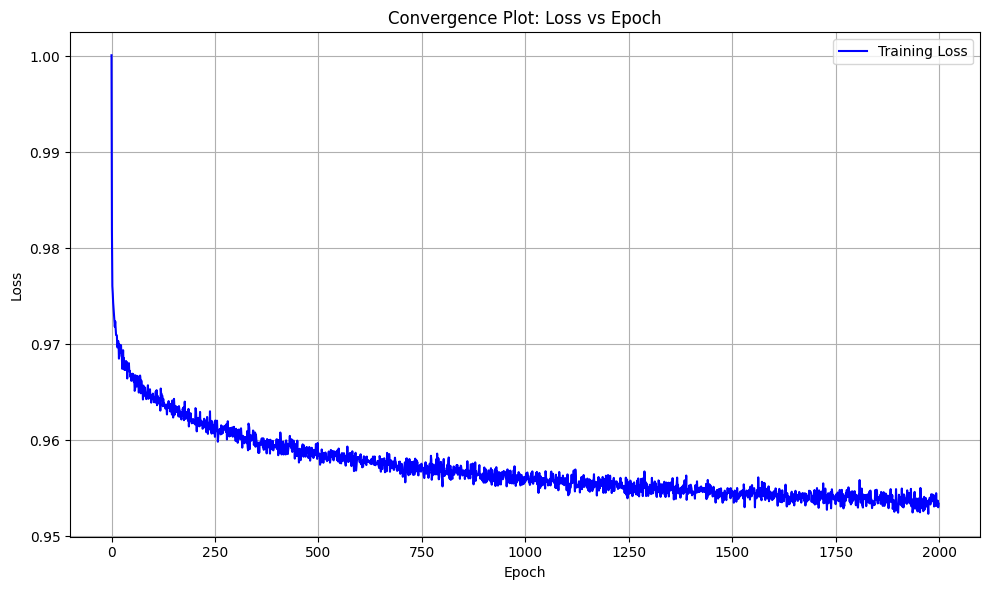

In [ ]:
epochs = range(len(loss_history))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_history, label='Training Loss', color='blue')
plt.title('Convergence Plot: Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
 # Forward pass on validation data
dense1.forward(X_val)
activation1.forward(dense1.outputs)

# dense2.forward(activation1.output)
# activation2.forward(dense2.outputs)

# dense2.O.forward(activation2.output)
# activation2.O.forward(dense2.O.outputs)

dense3.forward(activation1.output)
activation3.forward(dense3.outputs)

dense4.forward(activation3.output)
activation4.forward(dense4.outputs)


y_pred_probs = activation4.output
# y_pred = (y_pred_probs > 0.19465).astype(int).flatten()


In [ ]:
# Ground truth and predicted labels
y_true = y_val.flatten()
# y_pred = (y_pred_probs > 0.3948098606651744).astype(int).flatten()  # Predicted labels (binary)
y_pred = (y_pred_probs >  0.5).astype(int).flatten()

In [ ]:
print(y_pred_probs.shape)
print(y_pred.shape)
print(y_true.shape)

(14392, 1)
(14392,)
(14392,)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, confusion_matrix, precision_recall_curve


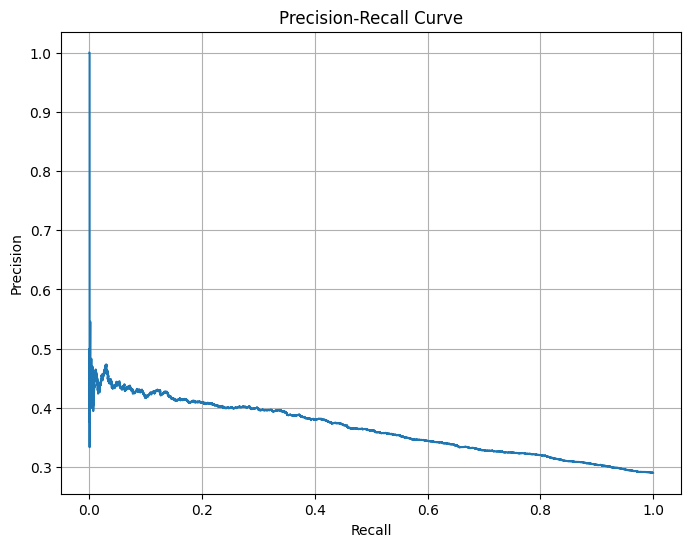

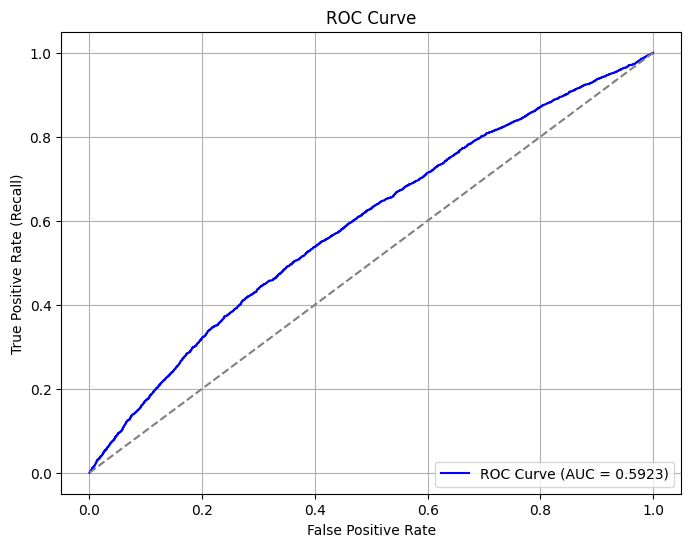

In [ ]:
import matplotlib.pyplot as plt

prec, rec, thresholds = precision_recall_curve(y_val, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

from sklearn.metrics import roc_curve, roc_auc_score



fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)


roc_auc = roc_auc_score(y_val, y_pred_probs)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:

acc = accuracy_score(y_val, y_pred)


f1 = f1_score(y_val, y_pred)

pr_auc = average_precision_score(y_val, y_pred_probs)

recall = recall_score(y_val, y_pred)
precision = precision_score(y_val,y_pred)

cm = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("Confusion Matrix:")
print(cm)


Accuracy: 0.5691
F1-score: 0.4312
Recall: 0.5627
Precision: 0.3495
PR-AUC: 0.3642
Confusion Matrix:
[[5839 4375]
 [1827 2351]]


In [ ]:

prec, rec, thresholds = precision_recall_curve(y_val, y_pred_probs)


with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * prec * rec / (prec + rec)
    f1_scores[np.isnan(f1_scores)] = 0

best_threshold_index = np.argmax(f1_scores)
best_threshold_value = thresholds[best_threshold_index]

print("Best F1-score:", f1_scores[best_threshold_index])
print("Best Threshold Value:", best_threshold_value)


Best F1-score: 0.45792935114245037
Best Threshold Value: 0.41621327029302757


In [ ]:
print("Well done my boy!!!!!")

Well done my boy!!!!!


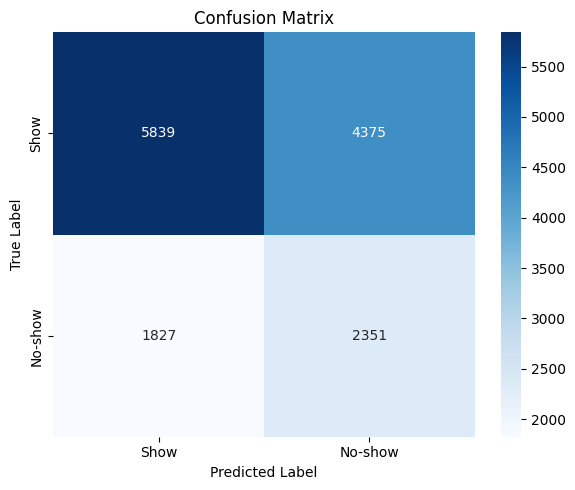

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



cm = confusion_matrix(y_val, y_pred)


labels = ['Show', 'No-show']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

